# Deep Networks

Here we will build the classifier using some deep networks with the `tersorflow` and `keras` library. Even though we do not have samples enough for this type of technique to be necessary, it is interesting to test how it will behavior, since usually it is pretty powerfull when there is a lot of samples. 


## Reading the data

In [1]:

import pandas as pd

data_path = './ifood-data-business-analyst-test/ml_project1_data.csv'
dataset = pd.read_csv(data_path)


## Preprocessing 

> Realise that this preprocessing is very close to the one presented before with in the XGBoost technique, therefore, if one wants to jump this part to the model part, please go for it.

Here we need to provide a simple preprocess to the data to remove possible non informative data, to create information fields that are more suitable for interpretation, some encoding of the features (since some are categorical), also we will make some normalization on the data to avoid over weighting errors and so on... 

> Notice that most functions to do the preprocessing here are implemented in a separated code, since it could be used for other models, and for later analysis.

In [2]:
from utils import *

### Pipeline

The preprocessing pipeline, for the XGBoost classification algorithm will be the one, as follows:

- `Step #1` First we will replace some fields with more interpretable information (Birth date => Age, Customer Registration => Persistence, ...)

- `Step #2` Then we are going to replace the categorical data set with an encoded one (categorical variables => numerical variables)

- `Step #3` Then some non informative features will be dropped from the analysis, _e.g._ features that are constant in all samples (which does not provide any information)

- `Step #4` Since we have only 24 samples with NaN (or null) values, we can drop those from the dataset, instead of concerning with interpolation and so on...

In [3]:

dataset = support.replaceFields(dataset)                # Step #1

dataset, encoders = support.encodeDataSet(dataset)      # Step #2

dataset = support.dropNonInformative(dataset)           # Step #3

df = dataset.dropna()                                   # Step #4


Features dropped: ['Z_CostContact', 'Z_Revenue']


Here we have some particular processing of the data for this particular Deep Network classifier algorithm. Notice that differently from the XGBoost approach, here the data is balanced by weighting the error importance of each sample. As described in the XGBoost section, the randomized approach is best suited for algorithms that does not use derivative search to optimize the model parameters, and Deep Networks use the classical deep learning technique to determine its parameters, which is a derivative based one. Therefore, the weighting technique based on the data proportions is feasible for this approach.

In summary, we will first build the regression problem as something close to the structure:

$$y(k) = f(\phi(k), \theta)$$

After we can normalize the data, by just making it fit the the group $[0, 1]$. Then, the regression format is created, using all the dataset. After the data will be divided into train and test groups, to then be defined the weighting of each sample error.

In [4]:

import numpy as np

# Regression format
phi = df.loc[:, ~df.columns.isin(['Response', 'ID'])].to_numpy()
target = df["Response"].to_numpy()

# Normalization
max_vals = np.amax(phi, axis=0)
min_vals = np.amin(phi, axis=0)
phi_n = (phi - max_vals) / (max_vals - min_vals)

X, y = phi_n, target 


### Train and Test data

Here we simply use the data to build the train and test sets:

In [5]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

# Weight of each sample
counts = np.bincount(y_train)
weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

weight_for_0, weight_for_1


(0.0007961783439490446, 0.0043859649122807015)

## Train model

Since the deep network model have soo many variables that could be defined as hyper parameters, usually for practical usage, it is enough to build a slightly complex model capable of generating good results by using handly tests, and from then refine its parameters. This usually it best, considering that this parameters are not only a lot of variables, but they also interfere the non-linearlly on the cost function creating several complex search surfaces, leading to several local minimuns... 

> _I know that for the XGBoost algorithm I built a global minimun searcher using annealing, but notice that it only searches for 3 parameters, here we are talking about something close to hundreds... So forgive for handly building a complex model. Hehe_ 

So here we are creating a descented deep network that has some dropouts to enhance consistency: 

In [6]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(X_train.shape[-1],)
        ),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               6656      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

In [7]:

metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)

callbacks = [keras.callbacks.ModelCheckpoint("model_at_epoch_{epoch}.h5")]
class_weight = {0: weight_for_0, 1: weight_for_1}

model.fit(
    X_train, y_train,
    batch_size=300,
    epochs=200,
    verbose=0,
    callbacks=callbacks,
    validation_data=(X_test, y_test),
    class_weight=class_weight)


  ...
    to  
  ['...']
  ...
    to  
  ['...']


## Model Results

Then here we can build some visualizations to show the results. The first one is the fitting with the testing data, using the confusion matrix to make sure the model is consistent. 


In [8]:

from sklearn.metrics import confusion_matrix

# Predict the testing output
y_pred = model.predict_classes(X_test)
# Compute the confusion matrix using test data
conf_mat = confusion_matrix(y_test, y_pred, normalize='true')


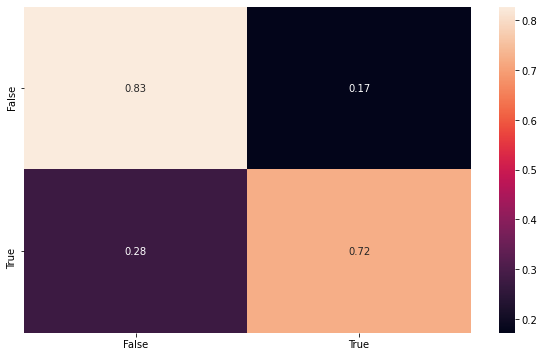

In [9]:

import seaborn as sns
import matplotlib.pyplot as plt

# Build the data for plot
index = ['False','True']  
cm_df = pd.DataFrame(conf_mat,index,index)                      

# Plot the confusion matrix
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True)


Here we can show the classification performance of the unbalaced dataset, using all samples, to be sure that the model maintain its consistency.

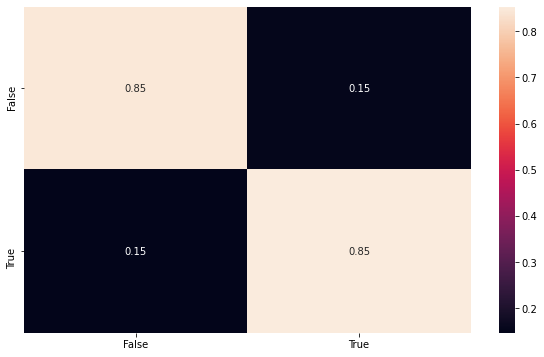

In [10]:

# Predict the testing output
y_pred = model.predict_classes(phi_n)
# Compute the confusion matrix using test data
conf_mat = confusion_matrix(target, y_pred, normalize='true')

# Build the data for plot
cm_df = pd.DataFrame(conf_mat,index,index)                      

# Plot the confusion matrix
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True)


## Saving the model

Lets save the model for further use:

In [11]:

# serialize model to YAML
model_yaml = model.to_yaml()
with open("DeepNet.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("DeepNet.h5")
